In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import tqdm
from jax import random, vmap, jit, grad
from jax.scipy.special import logsumexp

%matplotlib inline

In [2]:
KEY = random.PRNGKey(42)

         X1        X2 color  y
0  0.429440 -0.315818    c1  0
1  0.421166 -0.494174    c1  0
2 -0.303085  0.303412    c3  2
3 -0.010802 -0.320459    c2  1
4  0.303581 -0.479041    c1  0


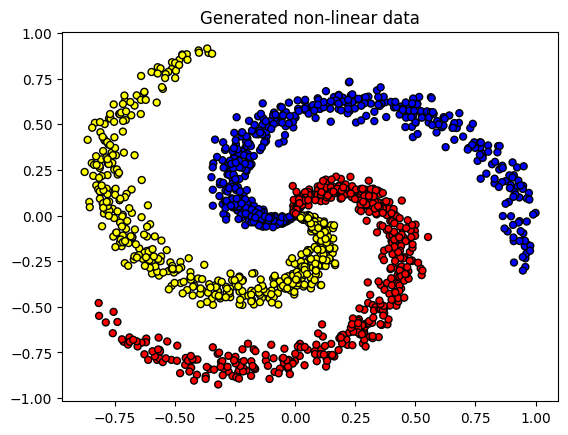

In [3]:
# Load this cool-looking dataset
url = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/spiral.csv"
df = pd.read_csv(url, header=0) # load
df = df.sample(frac=1).reset_index(drop=True) # shuffle
df['y'] = df['color'].str.replace("c", "").astype(int) - 1

print(df.head())

X = df[["X1", "X2"]].values
y = df["y"].values

plt.title("Generated non-linear data")
colors = {"c1": "red", "c2": "yellow", "c3": "blue"}
plt.scatter(X[:, 0], X[:, 1], c=[colors[_y] for _y in df['color'].values], edgecolors="k", s=25)
plt.show()

In [4]:
def create_linear_layer(input_dim: int, output_dim: int, scale=1e-2):
    return {
        'w': scale * random.normal(KEY, shape=(output_dim, input_dim)),
        'b': scale * random.normal(KEY, shape=(output_dim,))
    }

def create_linear_model(input_dim: int, output_dim: int, hidden_dim: int, n_layers: int):
    sizes = [input_dim] + [hidden_dim] * n_layers + [output_dim]
    return [create_linear_layer(i, o) for i, o in zip(sizes[:-1], sizes[1:])]

In [5]:
@jit
def linear(params, x):
    return jnp.dot(params['w'], x) + params['b']

@jit
def relu(x):
    return jnp.maximum(0, x)

In [6]:
def predict(model: list, x):
    for layer in model[:-1]:
        x = relu(linear(layer, x))

    final_layer = model[-1]
    logits = linear(final_layer, x)
    return logits - logsumexp(logits)

In [7]:
model = create_linear_model(2, 2, 128, 1)

Array([-0.70672506, -0.6797512 ], dtype=float32)

In [8]:
%%timeit
predict(model, X[0])

1.11 ms ± 120 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [9]:
predict = jit(predict)
predict(model, X[0]);

In [10]:
%%timeit
predict(model, X[0])

15.9 µs ± 2.24 µs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [11]:
batch_predict = vmap(predict, in_axes=(None, 0))

In [12]:
%%timeit
batch_predict(model, X)

2.31 ms ± 433 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
batch_predict = jit(batch_predict)
batch_predict(model, X);

In [14]:
%%timeit
batch_predict(model, X)

725 µs ± 68.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [15]:
def one_hot(x, k, dtype=jnp.float32):
    return jnp.array(x[:, None] == jnp.arange(k), dtype=dtype)

@jit
def loss(model, x, y):
    return -jnp.mean(batch_predict(model, x) * y)

grad_fn = jit(grad(loss))

@jit
def update(model, x, y, step_size=0.01):
    return jax.tree_map(lambda p, g: p - step_size * g, model, grad_fn(model, x, y))

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

n_classes = len(df['y'].unique())

X_train, X_tv, y_train, y_tv = train_test_split(X, y, test_size=0.3)
X_test, X_val, y_test, y_val = train_test_split(X_tv, y_tv, train_size=0.5)

scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

y_train = one_hot(y_train, n_classes)
y_test = one_hot(y_test, n_classes)
y_val = one_hot(y_val, n_classes)

model = create_linear_model(input_dim=2, output_dim=n_classes, hidden_dim=128, n_layers=1)

In [18]:
update(model, X_train[:10], y_train[:10]);

In [23]:
%%timeit model = create_linear_model(input_dim=2, output_dim=n_classes, hidden_dim=128, n_layers=1)
for _ in range(1000):
    model = update(model, X_train, y_train, step_size=0.05)

1.53 s ± 186 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
pbar = tqdm.tqdm(range(1000))
for _ in pbar:
    model = update(model, X_train, y_train, step_size=0.05)
    l = float(loss(model, X_val, y_val))
    pbar.set_description(f"loss={round(l, 2)}")

loss=0.08: 100%|██████████| 1000/1000 [00:02<00:00, 433.62it/s]
